Kode ini membuat CF dari LUC to Agri emission dibagi dg newly established GFRAC from natveg to agri

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
def ngfbfc_processing(df):
    try:
        if "type" in df.columns.to_list():
            df = df.rename(columns={"type": "NGFBFC"}) 

        if 'NGFBFC' in df.columns:
            df['NGFBFC'] = df['NGFBFC'].str.lower()
            if 'grass' in df['NGFBFC'].unique():
                df['NGFBFC'] = df['NGFBFC'].replace('grass', 'pasture')
            df['NGFBFC'] = df['NGFBFC'].replace("oil & palm fruit", "palm oil")
            df['NGFBFC'] = df['NGFBFC'].replace("other non-food & luxury & spices", "non food, luxury, spices")
            df['NGFBFC'] = df['NGFBFC'].replace('other temperate cereals', 'temperate cereals')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def region_processing(df):
    try:
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Kazakhstan region', 'Central Asia').replace('C. Europe', 'Central Europe').replace('E. Africa', 'Eastern Africa').replace('N. Africa', 'Northern Africa')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest C. America', 'Central America').replace('Rest S. Africa', 'Rest of Southern Africa').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest S. Asia', 'Rest of South Asia').replace('SE. Asia', 'Southeast Asia').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('W. Africa', 'Western Africa').replace('W. Europe', 'Western Europe').replace('Russia', 'Russia region')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Indonesia', 'Indonesia region').replace('China', 'China region').replace('Korea', 'Korea region')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def custom_mean(x):
  """Calculates the mean of non-zero values."""
  non_zero_values = x[x > 0]
  return non_zero_values.sum() / len(non_zero_values) if len(non_zero_values) > 0 else 0


def get_top_n(df, category_col, value_col, n=3):
    return df.groupby(category_col).apply(lambda x: x.nlargest(n, value_col)).reset_index(drop=True)

def get_angular_position(NGFBFC_name, NGFBFCs_list):
    """Calculate the angular position of a NGFBFC in the chart"""
    idx = NGFBFCs_list.index(NGFBFC_name)
    return (idx * 360.0 / len(NGFBFCs_list) + 90) % 360


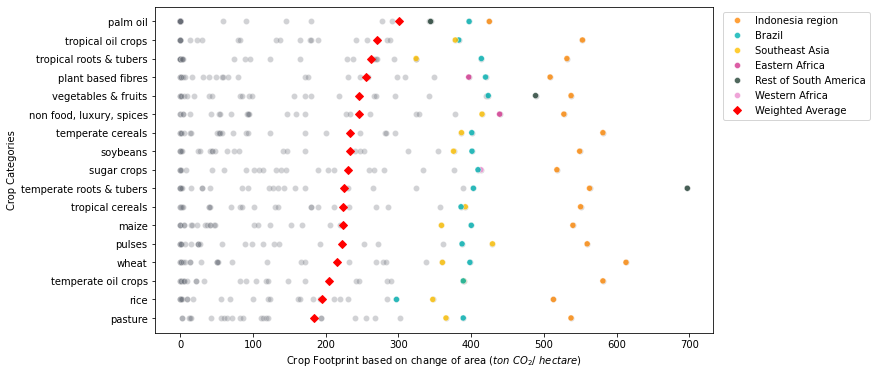

In [ ]:
data1 = pd.read_excel("../FULL_RUN/OUTPUT_DATA/luc_crop_per_crops_AM1.xlsx", sheet_name='Sheet1') 
data2 = pd.read_excel("../FULL_RUN/OUTPUT_DATA/natveg_to_crops.xlsx")
ccode_iso = pd.read_excel("../FULL_RUN/INPUT_DATA/ISO-3166-Country-Code_Final.xlsx")
ccode_iso = ccode_iso[['ISO Country', 'IMAGE Region Name']]

data2 = pd.merge(left=data2, right=ccode_iso, left_on=['country'], right_on=['ISO Country'])
data2.rename(columns={'country': 'country_name', "type": "NGFBFC"}, inplace=True)
data1.rename(columns={'country': 'country_name', "type": "NGFBFC"}, inplace=True)

len_ngfbfc = 17
std_dtype_float = np.float32
analysis_period = 10
columns_year_analysis = [int(i) for i in range(1975, 2020 + 1, 5)]

palettes = {'Oceania': '#B3C8CF','Japan':'#E5E483','Korea region':'#D2D180','China region':'#B2B377','Rest of South Asia':'#EF9595',
                'India':'#EFB495','Indonesia region':'#FF8A08','Southeast Asia':'#FFC100','Middle East':'#1B1A55','Central Asia':'#535C91',
                'Russia region':'#9290C3','Rest of Southern Africa':'#FF0000','South Africa':'#710019','Eastern Africa':'#D43790',
                'Western Africa':'#EC8FD0','Northern Africa':'#F2C5E0', 'Turkey':'#6F4E37','Ukraine region':'#A67B5B','Central Europe':'#ECB176',
                'Western Europe':'#FED8B1', 'Rest of South America':'#254336','Brazil':'#00b2b2','Central America':'#B3E2A7','Mexico':'#003285',
                'USA':'#40A2E3','Canada':'#BBE2EC'}

data2_copy = data2.copy()
data1_copy = data1.copy()

data2_copy = data2_copy.drop(columns=['origin'])

data2_melted = pd.melt(data2_copy, id_vars=['country_name', 'NGFBFC', 'IMAGE Region Name', 'ISO Country'], var_name='time', value_name='value')
data2_melted = data2_melted[['IMAGE Region Name', 'time', 'NGFBFC', 'value']]
data2_melted = data2_melted[~(data2_melted['IMAGE Region Name'] == "N|A")]
data2_melted = data2_melted[~data2_melted['NGFBFC'].str.contains("grass")]
data2_groupby = data2_melted.groupby(['IMAGE Region Name', 'time', 'NGFBFC']).sum()
data2_index = data2_groupby.reset_index()
data2_index['NGFBFC'] = data2_index['NGFBFC'].str.lower()

data1_melted = pd.melt(data1_copy, id_vars=['IMAGE Region Name', 'NGFBFC'], var_name='time', value_name='value')
data1_melted = data1_melted[~(data1_melted['IMAGE Region Name'] == "N|A")]
data1_melted = data1_melted[~data1_melted['NGFBFC'].str.contains("grass")]
data1_groupby = data1_melted.groupby(['IMAGE Region Name', 'time', 'NGFBFC']).sum()
data1_index = data1_groupby.reset_index()
data1_index['value'] = data1_index['value'] * 1E9

CF_LUCAgri = data1_index.copy()
CF_LUCAgri = CF_LUCAgri.drop(columns=['value'])
IMAGERegionName = CF_LUCAgri["IMAGE Region Name"].to_list()
time = CF_LUCAgri["time"].to_list()
type_ngfbfc = CF_LUCAgri["NGFBFC"].to_list()

for region, time, ngfbfc in zip(IMAGERegionName, time, type_ngfbfc):
    try:
        data1 = data1_index[(data1_index['IMAGE Region Name'] == region) & (data1_index['time'] == time) & (data1_index['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        data2 = data2_index[(data2_index['IMAGE Region Name'] == region) & (data2_index['time'] == time) & (data2_index['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        if data1.size == 0:
            data1 = [0]
        if data2.size == 0: 
            data2 = [0]
        mask = data1_index[(data1_index['IMAGE Region Name'] == region) & (data1_index['time'] == time) & (data1_index['NGFBFC'] == ngfbfc)].index
        CF_LUCAgri.loc[mask, 'CF'] = data1[0] / data2[0]
    except KeyError as e:
        print(f"Error: {e} for region {region}")

df_footprint_region = CF_LUCAgri.copy()
w_factor_footprint = data2_index.copy()

df_footprint_region = ngfbfc_processing(df_footprint_region)
w_factor_footprint = ngfbfc_processing(w_factor_footprint)

df_footprint_region['CF'] = df_footprint_region['CF'].replace([np.inf, -np.inf], np.nan).fillna(0)

average_ori = np.zeros((analysis_period, 16, 26), dtype=std_dtype_float)
average_AreaHarvested_RegionCrops = np.zeros((analysis_period, 16, 26), dtype=std_dtype_float)
weighted_average_1 = np.zeros((16, analysis_period), dtype=std_dtype_float)

for n, time in enumerate(columns_year_analysis):
    for i, ngfbfc in enumerate(df_footprint_region['NGFBFC'].unique()):
        for j, image_region in enumerate(w_factor_footprint['IMAGE Region Name'].unique()):
            ngfbfc_areaharves = w_factor_footprint[(w_factor_footprint['time'] == time) & (w_factor_footprint['IMAGE Region Name'] == image_region) & (w_factor_footprint['NGFBFC'] == ngfbfc)]['value'].replace([np.inf, -np.inf], np.nan).values
            average_AreaHarvested_RegionCrops[n][i][j] = np.nan_to_num(ngfbfc_areaharves)

for n, time in enumerate(columns_year_analysis):
    for i, ngfbfc in enumerate(df_footprint_region['NGFBFC'].unique()):
        carbon_footprint = df_footprint_region[(df_footprint_region['time'] == time) & (df_footprint_region['NGFBFC'] == ngfbfc)]['CF'].replace([np.inf, -np.inf], np.nan).values
        average_ori[n][i] = np.nan_to_num(carbon_footprint)

for i, ngfbfc in enumerate(df_footprint_region['NGFBFC'].unique()):
    for n, time in enumerate(columns_year_analysis):
        try:
            weighted_average_1[i][n] = np.average(average_ori[n][i], weights=average_AreaHarvested_RegionCrops[n][i])
        except:
            weighted_average_1[i][n] = 0

df_avg = pd.DataFrame(weighted_average_1, index=[df_footprint_region['NGFBFC'].unique()], columns=columns_year_analysis)
df_avg = df_avg.reset_index()
df_avg = df_avg.rename(columns={"level_0" : 'NGFBFC'})
df_avg_melt = pd.melt(
    df_avg, 
    id_vars=["NGFBFC"],  # Kolom yang tetap
    var_name="time",     # Nama kolom untuk nilai tahun
    value_name="value"   # Nama kolom untuk nilai data
)
df_avg = df_avg_melt.sort_values(by=['value', 'NGFBFC'], ascending=[False, False])

results = {}

for category in df_avg['NGFBFC'].unique():
    for time in columns_year_analysis:
        filtered_data = df_avg[(df_avg['NGFBFC'] == category) & (df_avg['time'] == time)]
        sorted_data = filtered_data.sort_values(by='value', ascending=False)
        top_5_data = sorted_data.head(3)
        if time not in results:
            results[time] = {}
        results[time][category] = top_5_data

df_avg = pd.concat([pd.concat(results[year].values()) for year in results.keys()])
df_avg = df_avg.sort_values(by=['time', 'value'], ascending=[True, False])
df_avg = ngfbfc_processing(df_avg)

CF_LUCAgri = region_processing(df_footprint_region)

CF_LUCAgri_table = pd.pivot_table(data=CF_LUCAgri, index=['NGFBFC', 'time'], columns=['IMAGE Region Name'])
CF_LUCAgri_index = CF_LUCAgri_table.stack(level=0, future_stack=True)
CF_LUCAgri_index = CF_LUCAgri_index.reset_index()
CF_LUCAgri_index = CF_LUCAgri_index.drop(columns=['level_2'])
CF_LUCAgri_index.index = CF_LUCAgri_index['NGFBFC'].values

average1_melt = CF_LUCAgri_index.melt(id_vars=['NGFBFC', 'time'], value_name='value') 
average1_melt = average1_melt[~((average1_melt['IMAGE Region Name'] == "Canada"))]
average1_melt = average1_melt[~((average1_melt['IMAGE Region Name'] == "Central America"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "tropical cereals") & (average1_melt['IMAGE Region Name'] == "Japan"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "South Africa"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "Rest of Southern Africa"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "USA"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "non food, luxury, spices") & (average1_melt['IMAGE Region Name'] == "Russia region"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "soybeans") & (average1_melt['IMAGE Region Name'] == "Southeast Asia"))]

average1_melt.index = average1_melt['NGFBFC'].values
average1_new = average1_melt.sort_values(by=['value', 'NGFBFC'], ascending=[True, True])

results = {}
for country in average1_new['IMAGE Region Name'].unique():
    for category in average1_new['NGFBFC'].unique():
        for time in columns_year_analysis:
            filtered_data = average1_new[(average1_new['NGFBFC'] == category) & (average1_new['time'] == time)]
            sorted_data = filtered_data.sort_values(by='value', ascending=False)
            top_5_data = sorted_data.head(3)
            if time not in results:
                results[time] = {}
            results[time][category] = top_5_data

df_footprint_df = pd.concat([pd.concat(results[year].values()) for year in results.keys()])

for time in columns_year_analysis:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Crop Footprint based on change of area ($ton~CO_2/~hectare$)')
    ax.set_ylabel('Crop Categories')

    plt.title(f"{time}")
    
    produk_diulang = np.array([item for item in df_avg[df_avg['time'] == time]['NGFBFC'].to_list() for _ in range(1)])

    sns.scatterplot(x="value", y="NGFBFC", color='#686D76', sizes=(100, 300), alpha=.3, data=average1_melt[average1_melt['time'] == time].loc[produk_diulang])

    sns.scatterplot(x="value", y="NGFBFC", hue='IMAGE Region Name', sizes=(100, 300), alpha=.8, palette=palettes, data=df_footprint_df[df_footprint_df['time'] == time])

    ax.legend(bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
    # ax.plot(df_avg[df_avg['time'] == time].sort_values(by='value', ascending=False)['value'].to_numpy(), df_avg[df_avg['time'] == time].sort_values(by='value', ascending=False)['NGFBFC'].to_numpy(), "D", color='red', label='Weighted Average')
    
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    weighted_average_index = legend_labels.index('Weighted Average')
    weighted_average_handle = legend_handles.pop(weighted_average_index)
    weighted_average_label = legend_labels.pop(weighted_average_index)
    legend_handles.append(weighted_average_handle)
    legend_labels.append(weighted_average_label)

    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
    ax.xaxis.set_major_locator(MultipleLocator(5))

    plt.show()

data2_melted = pd.melt(data2_copy, id_vars=['country_name', 'NGFBFC', 'IMAGE Region Name', 'ISO Country'], var_name='time', value_name='value')
data2_columns = data2_melted[['IMAGE Region Name', 'time', 'NGFBFC', 'value']]
data2_groupby = data2_columns.groupby(['IMAGE Region Name', 'time', 'NGFBFC']).sum()
data2_index = data2_groupby.reset_index()
data2_index['NGFBFC'] = data2_index['NGFBFC'].str.lower()

data1_melted = pd.melt(data1_copy, id_vars=['IMAGE Region Name', 'NGFBFC'], var_name='time', value_name='value')
data1_groupby = data1_melted.groupby(['IMAGE Region Name', 'time', 'NGFBFC']).sum()
data1_index = data1_groupby.reset_index()
data1_index['value'] = data1_index['value'] * 1E9

CF_LUCAgri = data1_index.copy()
CF_LUCAgri = CF_LUCAgri.drop(columns=['value'])
IMAGERegionName = CF_LUCAgri["IMAGE Region Name"].to_list()
time = CF_LUCAgri["time"].to_list()
type_ngfbfc = CF_LUCAgri["NGFBFC"].to_list()

for region, time, ngfbfc in zip(IMAGERegionName, time, type_ngfbfc):
    try:
        data1 = data1_index[(data1_index['IMAGE Region Name'] == region) & (data1_index['time'] == time) & (data1_index['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        data2 = data2_index[(data2_index['IMAGE Region Name'] == region) & (data2_index['time'] == time) & (data2_index['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        if data1.size == 0:
            data1 = [0]
        if data2.size == 0: 
            data2 = [0]
        mask = data1_index[(data1_index['IMAGE Region Name'] == region) & (data1_index['time'] == time) & (data1_index['NGFBFC'] == ngfbfc)].index
        CF_LUCAgri.loc[mask, 'CF'] = data1[0] / data2[0]
    except KeyError as e:
        print(f"Error: {e} for region {region}")

df_footprint_region = CF_LUCAgri.copy()
w_factor_footprint = data2_index.copy()

w_factor_footprint = w_factor_footprint.set_index(['IMAGE Region Name', 'time', 'NGFBFC']).loc[CF_LUCAgri.set_index(['IMAGE Region Name', 'time', 'NGFBFC']).index].reset_index()

average_ori = np.zeros((len_ngfbfc, 26), dtype=std_dtype_float)
average_AreaHarvested_RegionCrops = np.zeros((len_ngfbfc, 26), dtype=std_dtype_float)
weighted_average_1 = np.zeros((len_ngfbfc), dtype=std_dtype_float)
for i, ngfbfc in enumerate(CF_LUCAgri['NGFBFC'].unique()):
    for n, image_region in enumerate(w_factor_footprint['IMAGE Region Name'].unique()):
        ngfbfc_areaharves = w_factor_footprint[(w_factor_footprint['IMAGE Region Name'] == image_region) & (w_factor_footprint['NGFBFC'] == ngfbfc) & (w_factor_footprint['value'] > 0)]['value'].replace([np.inf, -np.inf], np.nan).mean()
        average_AreaHarvested_RegionCrops[i][n] = np.nan_to_num(ngfbfc_areaharves)

for i, ngfbfc in enumerate(CF_LUCAgri['NGFBFC'].unique()):
    carbon_footprint = CF_LUCAgri[CF_LUCAgri['NGFBFC'] == ngfbfc]['CF'].replace([np.inf, -np.inf], np.nan).mean()
    average_ori[i] = np.nan_to_num(carbon_footprint)

for i, ngfbfc in enumerate(CF_LUCAgri['NGFBFC'].unique()):
    weighted_average_1[i] = np.average(average_ori[i], weights=average_AreaHarvested_RegionCrops[i]) #nilai rata rata juga tidak hanya 2020

df_weighted_average_1 = pd.DataFrame(weighted_average_1, index=CF_LUCAgri['NGFBFC'].unique())
df_weighted_average_1 = df_weighted_average_1.reset_index()
df_weighted_average_1 = df_weighted_average_1.rename(columns={"index": 'NGFBFC', 0:"value"})
df_weighted_average_1 = df_weighted_average_1.sort_values(by=['value'], ascending=[False])
df_weighted_average_1['NGFBFC'] = df_weighted_average_1['NGFBFC'].replace('grass', 'pasture').replace('oil & palm fruit', 'palm oil').replace('other non-food & luxury & spices', 'non food, luxury, spices').replace('other temperate cereals', 'temperate cereals')
produk_diulang = np.array([item for item in df_weighted_average_1['NGFBFC'].to_list() for _ in range(1)])

CF_LUCAgri = CF_LUCAgri.replace([np.inf, -np.inf], np.nan).fillna(0)
CF_LUCAgri['NGFBFC'] = CF_LUCAgri['NGFBFC'].replace('grass', 'pasture').replace('oil & palm fruit', 'palm oil').replace('other non-food & luxury & spices', 'non food, luxury, spices').replace('other temperate cereals', 'temperate cereals')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('Kazakhstan region', 'Central Asia').replace('C. Europe', 'Central Europe').replace('E. Africa', 'Eastern Africa').replace('N. Africa', 'Northern Africa')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('Rest C. America', 'Central America').replace('Rest S. Africa', 'Rest of Southern Africa').replace('Rest S. America', 'Rest of South America')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('Rest S. Asia', 'Rest of South Asia').replace('SE. Asia', 'Southeast Asia').replace('Rest S. America', 'Rest of South America')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('W. Africa', 'Western Africa').replace('W. Europe', 'Western Europe').replace('Russia', 'Russia region')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('Indonesia', 'Indonesia region').replace('China', 'China region').replace('Korea', 'Korea region')

CF_LUCAgri_table = pd.pivot_table(data=CF_LUCAgri, index=['NGFBFC', 'time'], columns=['IMAGE Region Name'])
CF_LUCAgri_index = CF_LUCAgri_table.stack(level=0, future_stack=True)
CF_LUCAgri_index = CF_LUCAgri_index.reset_index()
CF_LUCAgri_index = CF_LUCAgri_index.drop(columns=['level_2'])
CF_LUCAgri_index = CF_LUCAgri_index.drop(columns=['time'])
CF_LUCAgri_index.index = CF_LUCAgri_index['NGFBFC'].values

CF_LUCAgri_index = CF_LUCAgri_index.loc[produk_diulang]
CF_LUCAgri_index_melt = CF_LUCAgri_index.melt(id_vars=['NGFBFC'], value_name='value')

CF_LUCAgri_index_melt_mean = CF_LUCAgri_index_melt.groupby(['IMAGE Region Name', 'NGFBFC'])['value'].apply(custom_mean).to_frame('Mean')
CF_LUCAgri_index_melt_mean_index = CF_LUCAgri_index_melt_mean.reset_index()

CF_LUCAgri_index_melt_mean_index.index = CF_LUCAgri_index_melt_mean_index['NGFBFC'].values
CF_LUCAgri_index_melt_mean_index_filtered = CF_LUCAgri_index_melt_mean_index[CF_LUCAgri_index_melt_mean_index['Mean'] < 1000000000]

results = {}
CF_LUCAgri_index_melt_mean_index_filtered_sort = CF_LUCAgri_index_melt_mean_index_filtered.sort_values(by=['Mean', 'NGFBFC'], ascending=[True, True])
CF_LUCAgri_index_melt_mean_index_filtered_sort = CF_LUCAgri_index_melt_mean_index_filtered_sort[~((CF_LUCAgri_index_melt_mean_index_filtered_sort['IMAGE Region Name'] == "Central America"))]

for country in CF_LUCAgri_index_melt_mean_index_filtered_sort['IMAGE Region Name'].unique():
    for category in CF_LUCAgri_index_melt_mean_index_filtered_sort['NGFBFC'].unique():
        filtered_data = CF_LUCAgri_index_melt_mean_index_filtered_sort[CF_LUCAgri_index_melt_mean_index_filtered_sort['NGFBFC'] == category]
        sorted_data = filtered_data.sort_values(by='Mean', ascending=False)
        top_3_data = sorted_data.head(3)
        results[category] = top_3_data

CF_LUCAgri_final_top_3 = pd.concat([pd.concat(results.values())])

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Crop Footprint based on change of area ($ton~CO_2/~hectare$)')
ax.set_ylabel('Crop Categories')

sns.scatterplot(x="Mean", y="NGFBFC", color='#686D76', sizes=(100, 300), alpha=.3, data=CF_LUCAgri_index_melt_mean_index_filtered_sort.loc[produk_diulang])
sns.scatterplot(x="Mean", y="NGFBFC", hue='IMAGE Region Name', sizes=(100, 300), alpha=.8, palette=palettes, data=CF_LUCAgri_final_top_3)

ax.legend(bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')

ax.plot(df_weighted_average_1['value'].to_numpy(), df_weighted_average_1['NGFBFC'].to_numpy(), "D", color='red', label='Weighted Average')
legend_handles, legend_labels = ax.get_legend_handles_labels()

weighted_average_index = legend_labels.index('Weighted Average')

weighted_average_handle = legend_handles.pop(weighted_average_index)
weighted_average_label = legend_labels.pop(weighted_average_index)
legend_handles.append(weighted_average_handle)
legend_labels.append(weighted_average_label)

ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')

plt.show()

In [2]:
data1 = pd.read_excel("Z:/achaidir/IMAGE PBL/visualisasi CF CI/luc_crop_per_crops_AM1_region_reorder.xlsx", sheet_name = 'Sheet1') #v1
#data1 = pd.read_excel("Z:/achaidir/IMAGE PBL/maps/luc_agri_per_crops_AM1_v2_region_reordered.xlsx", sheet_name = 'Sheet1') #v2
data2 = pd.read_excel("Z:/achaidir/IMAGE PBL/visualisasi CF CI/natveg2crops_v5_concat.xlsx")
ccode_iso = pd.read_excel("Z:/achaidir/Country Grids/ISO-3166-Country-Code_Final.xlsx")

In [3]:
data1

,IMAGE Region Name,type,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
0,Brazil,maize,4.190159e-01,0.192794,0.145007,0.433248,1.176752,0.325381,0.238095,0.025918,0.320864,0.193690
1,Brazil,oil & palm fruit,2.493429e-04,0.000052,0.000232,0.001785,0.007002,0.003170,0.002644,0.000060,0.002675,0.001031
2,Brazil,other non-food & luxury & spices,1.089310e-01,0.055279,0.047116,0.106872,0.267362,0.077741,0.000000,0.000031,0.020162,0.012583
3,Brazil,other temperate cereals,1.227032e-02,0.007969,0.005865,0.015972,0.042689,0.014502,0.012261,0.000635,0.010400,0.003574
4,Brazil,plant based fibres,2.072625e-01,0.093731,0.048800,0.066367,0.094793,0.021525,0.016303,0.000000,0.019586,0.005895
...,...,...,...,...,...,...,...,...,...,...,...,...
437,W. Europe,tropical oil crops,2.431061e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
438,W. Europe,tropical roots & tubers,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
439,W. Europe,vegetables & fruits,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
440,W. Europe,wheat,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
data2 = data2.drop(columns=['origin'])
data2_melted = pd.melt(data2, id_vars=['country', 'type'], var_name='time', value_name='value')
data2_merge = pd.merge(left=data2_melted, right=ccode_iso, left_on=['country'], right_on=['ISO Country'])
data2_columns = data2_merge[['IMAGE Region Name', 'time', 'type', 'value']]
data2_groupby = data2_columns.groupby(['IMAGE Region Name', 'time', 'type']).sum()
data2_index = data2_groupby.reset_index()
data2_index['type'] = data2_index['type'].str.lower()
# data2_index.to_excel("Z:/achaidir/IMAGE PBL/visualisasi CF CI/data2_crops.xlsx",  index=False)

In [5]:
data1_melted = pd.melt(data1, id_vars=['IMAGE Region Name', 'type'], var_name='time', value_name='value')
data1_groupby = data1_melted.groupby(['IMAGE Region Name', 'time', 'type']).sum()
data1_index = data1_groupby.reset_index()
data1_index['value'] = data1_index['value'] * 1E9
# data1_index.to_excel("Z:/achaidir/IMAGE PBL/visualisasi CF CI/data1_crops.xlsx",  index=False)

In [6]:
CF_LUCAgri = data1_index.copy()
CF_LUCAgri = CF_LUCAgri.drop(columns=['value'])
IMAGERegionName = CF_LUCAgri["IMAGE Region Name"].to_list()
time = CF_LUCAgri["time"].to_list()
type_ngfbfc = CF_LUCAgri["type"].to_list()

for region, time, ngfbfc in zip(IMAGERegionName, time, type_ngfbfc):
    try:
        data1 = data1_index[(data1_index['IMAGE Region Name'] == region) & (data1_index['time'] == time) & (data1_index['type'] == ngfbfc)]['value'].to_numpy()
        data2 = data2_index[(data2_index['IMAGE Region Name'] == region) & (data2_index['time'] == time) & (data2_index['type'] == ngfbfc)]['value'].to_numpy()
        if data1.size == 0:
            data1 = [0]
        if data2.size == 0: 
            data2 = [0]
        mask = data1_index[(data1_index['IMAGE Region Name'] == region) & (data1_index['time'] == time) & (data1_index['type'] == ngfbfc)].index
        CF_LUCAgri.loc[mask, 'CF'] = data1[0] / data2[0]
    except KeyError as e:
        print(f"Error: {e} for region {region}")

In [7]:
# CF_LUCAgri.to_excel("Z:/achaidir/IMAGE PBL/visualisasi CF CI/CF_LUCAgri_newGFRAC_crops.xlsx",  index=False)

In [8]:
df_footprint_region = CF_LUCAgri
w_factor_footprint = data2_index

In [9]:
w_factor_footprint = w_factor_footprint.set_index(['IMAGE Region Name', 'time', 'type']).loc[CF_LUCAgri.set_index(['IMAGE Region Name', 'time', 'type']).index].reset_index()

In [10]:
w_factor_footprint[(w_factor_footprint['IMAGE Region Name'] == "W. Europe") & (w_factor_footprint['type'] == 'sugar crops') & (w_factor_footprint['value'] > 0)]['value'].replace([np.inf, -np.inf], np.nan).mean()

2194980.9044799805

In [11]:
average_ori = np.zeros((17, 26), dtype='float32')
average_AreaHarvested_RegionCrops = np.zeros((17, 26), dtype='float32')
weighted_average_1 = np.zeros((17), dtype='float32')

for i, ngfbfc in enumerate(CF_LUCAgri['type'].unique()):
    for n, image_region in enumerate(w_factor_footprint['IMAGE Region Name'].unique()):
        ngfbfc_areaharves = w_factor_footprint[(w_factor_footprint['IMAGE Region Name'] == image_region) & (w_factor_footprint['type'] == ngfbfc) & (w_factor_footprint['value'] > 0)]['value'].replace([np.inf, -np.inf], np.nan).mean()
        average_AreaHarvested_RegionCrops[i][n] = np.nan_to_num(ngfbfc_areaharves)

for i, ngfbfc in enumerate(CF_LUCAgri['type'].unique()):
    carbon_footprint = CF_LUCAgri[CF_LUCAgri['type'] == ngfbfc]['CF'].replace([np.inf, -np.inf], np.nan).mean()
    average_ori[i] = np.nan_to_num(carbon_footprint)

for i, ngfbfc in enumerate(CF_LUCAgri['type'].unique()):
    weighted_average_1[i] = np.average(average_ori[i], weights=average_AreaHarvested_RegionCrops[i]) #nilai rata rata juga tidak hanya 2020

In [12]:
weighted_average_1

array([184.38689, 223.33043, 300.27905, 245.75128, 234.2258 , 255.48419,
       222.3482 , 194.79247, 233.0048 , 230.48581, 204.36832, 225.35046,
       224.07936, 270.2775 , 262.0244 , 246.53279, 215.25116],
      dtype=float32)

In [13]:
df_weighted_average_1 = pd.DataFrame(weighted_average_1, index=CF_LUCAgri['type'].unique())
df_weighted_average_1 = df_weighted_average_1.reset_index()
df_weighted_average_1 = df_weighted_average_1.rename(columns={"index":'type', 0:"value"})
df_weighted_average_1 = df_weighted_average_1.sort_values(by=['value'], ascending=[False])
df_weighted_average_1['type'] = df_weighted_average_1['type'].replace('grass', 'pasture').replace('oil & palm fruit', 'palm oil').replace('other non-food & luxury & spices', 'non food, luxury, spices').replace('other temperate cereals', 'temperate cereals')
produk_diulang = np.array([item for item in df_weighted_average_1['type'].to_list() for _ in range(1)])
df_weighted_average_1

,type,value
2,palm oil,300.279053
13,tropical oil crops,270.277496
14,tropical roots & tubers,262.024414
5,plant based fibres,255.484192
15,vegetables & fruits,246.532791
3,"non food, luxury, spices",245.751282
4,temperate cereals,234.225800
8,soybeans,233.004807
9,sugar crops,230.485809
11,temperate roots & tubers,225.350464


In [14]:
CF_LUCAgri = CF_LUCAgri.replace([np.inf, -np.inf], np.nan).fillna(0)
CF_LUCAgri['type'] = CF_LUCAgri['type'].replace('grass', 'pasture').replace('oil & palm fruit', 'palm oil').replace('other non-food & luxury & spices', 'non food, luxury, spices').replace('other temperate cereals', 'temperate cereals')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('Kazakhstan region', 'Central Asia').replace('C. Europe', 'Central Europe').replace('E. Africa', 'Eastern Africa').replace('N. Africa', 'Northern Africa')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('Rest C. America', 'Central America').replace('Rest S. Africa', 'Rest of Southern Africa').replace('Rest S. America', 'Rest of South America')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('Rest S. Asia', 'Rest of South Asia').replace('SE. Asia', 'Southeast Asia').replace('Rest S. America', 'Rest of South America')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('W. Africa', 'Western Africa').replace('W. Europe', 'Western Europe').replace('Russia', 'Russia region')
CF_LUCAgri['IMAGE Region Name'] = CF_LUCAgri['IMAGE Region Name'].replace('Indonesia', 'Indonesia region').replace('China', 'China region').replace('Korea', 'Korea region')
CF_LUCAgri_table = pd.pivot_table(data=CF_LUCAgri, index=['type', 'time'], columns=['IMAGE Region Name'])
CF_LUCAgri_index = CF_LUCAgri_table.stack(level=0)
CF_LUCAgri_index = CF_LUCAgri_index.reset_index()
CF_LUCAgri_index = CF_LUCAgri_index.drop(columns=['level_2'])
CF_LUCAgri_index = CF_LUCAgri_index.drop(columns=['time'])
CF_LUCAgri_index.index = CF_LUCAgri_index['type'].values

#mengurutkan data CF seperti urutan weighted average
CF_LUCAgri_index = CF_LUCAgri_index.loc[produk_diulang]
CF_LUCAgri_index_melt = CF_LUCAgri_index.melt(id_vars=['type'], value_name='value')


In [15]:
def custom_mean(x):
  """Calculates the mean of non-zero values."""
  non_zero_values = x[x > 0]
  return non_zero_values.sum() / len(non_zero_values) if len(non_zero_values) > 0 else 0

CF_LUCAgri_index_melt_mean = CF_LUCAgri_index_melt.groupby(['IMAGE Region Name', 'type'])['value'].apply(custom_mean).to_frame('Mean')
CF_LUCAgri_index_melt_mean_index = CF_LUCAgri_index_melt_mean.reset_index()


In [16]:
CF_LUCAgri_index_melt_mean_index[(CF_LUCAgri_index_melt_mean_index['IMAGE Region Name'] == 'Western Africa') & (CF_LUCAgri_index_melt_mean_index['type'] == 'tropical cereals')]

,IMAGE Region Name,type,Mean
420,Western Africa,tropical cereals,232.440305


In [23]:
CF_LUCAgri_index_melt_mean_index_filtered_sort

,IMAGE Region Name,type,Mean
maize,Central Europe,maize,0.000000
maize,Northern Africa,maize,0.000000
maize,Western Europe,maize,0.000000
"non food, luxury, spices",Japan,"non food, luxury, spices",0.000000
"non food, luxury, spices",Western Europe,"non food, luxury, spices",0.000000
...,...,...,...
temperate cereals,Indonesia region,temperate cereals,581.146617
temperate oil crops,Indonesia region,temperate oil crops,581.146656
pulses,Central America,pulses,594.812876
wheat,Indonesia region,wheat,612.872738


In [24]:
CF_LUCAgri_index_melt_mean_index.index = CF_LUCAgri_index_melt_mean_index['type'].values
CF_LUCAgri_index_melt_mean_index_filtered = CF_LUCAgri_index_melt_mean_index[CF_LUCAgri_index_melt_mean_index['Mean'] < 1000000000]

results = {}
CF_LUCAgri_index_melt_mean_index_filtered_sort = CF_LUCAgri_index_melt_mean_index_filtered.sort_values(by=['Mean', 'type'], ascending=[True, True])
CF_LUCAgri_index_melt_mean_index_filtered_sort = CF_LUCAgri_index_melt_mean_index_filtered_sort[~((CF_LUCAgri_index_melt_mean_index_filtered_sort['IMAGE Region Name'] == "Central America"))]

for country in CF_LUCAgri_index_melt_mean_index_filtered_sort['IMAGE Region Name'].unique():
    for category in CF_LUCAgri_index_melt_mean_index_filtered_sort['type'].unique():
        filtered_data = CF_LUCAgri_index_melt_mean_index_filtered_sort[CF_LUCAgri_index_melt_mean_index_filtered_sort['type'] == category]
        sorted_data = filtered_data.sort_values(by='Mean', ascending=False)
        top_3_data = sorted_data.head(3)
        results[category] = top_3_data

CF_LUCAgri_final_top_3 = pd.concat([pd.concat(results.values())])

In [25]:
unique_counts = CF_LUCAgri_final_top_3['IMAGE Region Name'].value_counts()
unique_counts

Indonesia region         17
Brazil                   16
Southeast Asia           12
Rest of South America     3
Eastern Africa            2
Western Africa            1
Name: IMAGE Region Name, dtype: int64

In [26]:
CF_LUCAgri_final_top_3

,IMAGE Region Name,type,Mean
maize,Indonesia region,maize,539.906597
maize,Brazil,maize,400.207588
maize,Southeast Asia,maize,359.293216
"non food, luxury, spices",Indonesia region,"non food, luxury, spices",527.484054
"non food, luxury, spices",Eastern Africa,"non food, luxury, spices",439.182454
"non food, luxury, spices",Southeast Asia,"non food, luxury, spices",415.002130
palm oil,Indonesia region,palm oil,425.007361
palm oil,Brazil,palm oil,397.241111
palm oil,Rest of South America,palm oil,344.293487
plant based fibres,Indonesia region,plant based fibres,508.594328


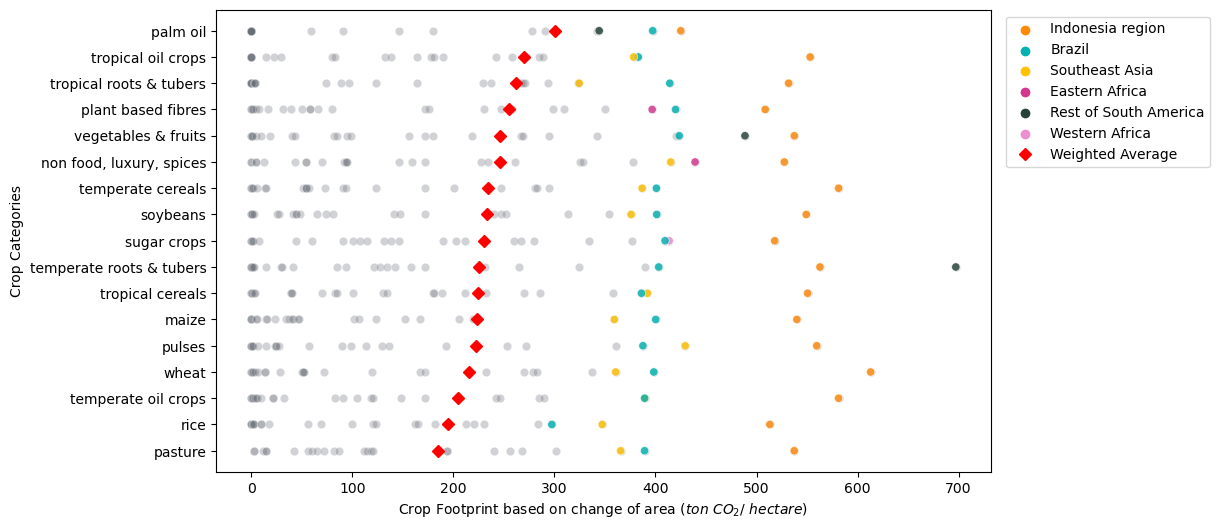

In [32]:
import numpy as np
import pandas as pd
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 6))

palettes = {'Oceania': '#B3C8CF','Japan':'#E5E483','Korea region':'#D2D180','China region':'#B2B377','Rest of South Asia':'#EF9595',
                'India':'#EFB495','Indonesia region':'#FF8A08','Southeast Asia':'#FFC100','Middle East':'#1B1A55','Central Asia':'#535C91',
                'Russia region':'#9290C3','Rest of Southern Africa':'#FF0000','South Africa':'#710019','Eastern Africa':'#D43790',
                'Western Africa':'#EC8FD0','Northern Africa':'#F2C5E0', 'Turkey':'#6F4E37','Ukraine region':'#A67B5B','Central Europe':'#ECB176',
                'Western Europe':'#FED8B1', 'Rest of South America':'#254336','Brazil':'#00b2b2','Central America':'#B3E2A7','Mexico':'#003285',
                'USA':'#40A2E3','Canada':'#BBE2EC'}

ax.set_xlabel('Crop Footprint based on change of area ($ton~CO_2/~hectare$)')
ax.set_ylabel('Crop Categories')

#Plot all data as grey
sns.scatterplot(x="Mean", y="type", color='#686D76',
                sizes=(100, 300), alpha=.3, data=CF_LUCAgri_index_melt_mean_index_filtered_sort.loc[produk_diulang])

#Plot top 3 data as colour
sns.scatterplot(x="Mean", y="type", hue='IMAGE Region Name',
                sizes=(100, 300), alpha=.8, palette=palettes, data=CF_LUCAgri_final_top_3)
ax.legend(bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')

#Plot weighted average
ax.plot(df_weighted_average_1['value'].to_numpy(), df_weighted_average_1['type'].to_numpy(), "D", color='red', label='Weighted Average')
legend_handles, legend_labels = ax.get_legend_handles_labels()

weighted_average_index = legend_labels.index('Weighted Average')

weighted_average_handle = legend_handles.pop(weighted_average_index)
weighted_average_label = legend_labels.pop(weighted_average_index)
legend_handles.append(weighted_average_handle)
legend_labels.append(weighted_average_label)

ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')

plt.show()

In [28]:
df_weighted_average_1['value'].min(), df_weighted_average_1['value'].max()

(184.38689, 300.27905)

In [29]:
df_weighted_average_1

,type,value
2,palm oil,300.279053
13,tropical oil crops,270.277496
14,tropical roots & tubers,262.024414
5,plant based fibres,255.484192
15,vegetables & fruits,246.532791
3,"non food, luxury, spices",245.751282
4,temperate cereals,234.225800
8,soybeans,233.004807
9,sugar crops,230.485809
11,temperate roots & tubers,225.350464
